# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

4431872/4422102 [==============================] - 0s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import Normalizer

import timeit


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        self.normalizer = Normalizer()
        start = timeit.default_timer()
        X = self.normalizer.fit_transform(X)
        if self.use_PCA:
          self.pca = PCA(n_components=self.new_dim)
          X = self.pca.fit_transform(X)
        else:
          self.new_dim = X.shape[1]
        self.sigma = 1 / self.__get_sigma__(X) 
        self.w = np.random.normal(0, self.sigma, [self.new_dim, self.n_features])
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        X_new = np.cos(X@self.w + self.b)
        if self.classifier == 'logreg':
          self.classifier = LogisticRegression(random_state=0, verbose=False)
        else:
          self.classifier = SVC(random_state=0, verbose=True)

        self.classifier = self.classifier.fit(X_new, y)

        stop = timeit.default_timer()

        print(f'RFFP (PCA: {self.use_PCA}, Time: ', stop - start)  
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
         X = self.pca.transform(X)
        X = np.cos(X@self.w + self.b)

        pred = self.classifier.predict_proba(X)
        return pred

        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
         X = self.pca.transform(X)
        X = np.cos(X@self.w + self.b)

        pred = self.classifier.predict(X)
        return pred

    def __get_sigma__(self, X, num_pairs:int = 1000000):

    '''
    Function to calculate sigma
    '''
      med_values = []
      for num_pairs in range(num_pairs):
        i, j = np.random.randint(X.shape[0], size=2)
        if i == j:
          continue
        dif = 0
        for k in range(X.shape[1]):
          dif += (X[i][k] - X[j][k])**2
        med_values.append(dif)
      return np.median(med_values)

In [4]:
rff = RFFPipeline()
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)

accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  197.71152007199998


0.8631

**Время обучения RFF with PCA**: 197.71 sec

**Полученная точность на тесте**: 0.8631

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

##RFF vs SVM

In [ ]:
from sklearn.pipeline import make_pipeline

def get_svc_score(X_train, X_test, y_train, y_test, kernel:str='linear'):
  '''
  function to train SVC and estimate fitted model
  '''
  assert kernel in ['linear', 'poly', 'rbf', 'sigmoid']
  start = timeit.default_timer()  
  clf = make_pipeline(Normalizer(), SVC(kernel=kernel))
  clf.fit(X_train, y_train)
  stop = timeit.default_timer()
  y_test = clf.predict(X_test)
  print(f'SVC (Kernel {kernel}): {accuracy_score(y_test, y_pred)}. Time: {stop-start}')

In [ ]:
get_svc_score(x_train, x_test, y_train, y_test, kernel='linear')
get_svc_score(x_train, x_test, y_train, y_test, kernel='rbf')


SVC (Kernel linear): 0.8989. Time: 820.4229728209993
SVC (Kernel rbf): 0.9274. Time: 797.6187836219997


**Итог:** 

При прочих равных SVC показывает результаты немногим выше, чем RFF. Однако время обучения SVC в 7-8 раз больше, чем RFF.
Какую модель выбрать - зависит от требований к задаче.

## RFF vs XGBoost

In [7]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
start = timeit.default_timer()
xgb_clf.fit(x_train, y_train)
stop = timeit.default_timer()
y_test = xgb_clf.predict(x_test)
print(f'XGBoost: {accuracy_score(y_test, y_pred)}, Time: {stop-start}')ы

XGBoost: 0.8882, Time: 960.4361493780002


In [10]:
from sklearn.pipeline import make_pipeline

#C нормализованными данными
start = timeit.default_timer()  
xgb_clf = make_pipeline(Normalizer(), xgb.XGBClassifier())
xgb_clf.fit(x_train, y_train)
stop = timeit.default_timer()
y_test = xgb_clf.predict(x_test)
print(f'XGBoost: {accuracy_score(y_test, y_pred)}, Time: {stop-start}')


XGBoost: 0.8946, Time: 1927.8936499070005


**Итог:**
 Качество модели +- одинаково, однако скорость обучения RFF значительно ниже.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

## PCA Trus vs PCA False

In [ ]:
from sklearn.metrics import accuracy_score

rff = RFFPipeline(use_PCA=True)
rff.fit(x_train, y_train)
y_pred_pca = rff.predict(x_test)

rff = RFFPipeline(use_PCA=False)
rff.fit(x_train, y_train)
y_pred_no_pca = rff.predict(x_test)


print(f'RFF with PCA: {accuracy_score(y_test, y_pred_pca)}\nRFF without PCA: {accuracy_score(y_test, y_pred_no_pca)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  200.70620892599982


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: False, Time:  1227.2595537019997
RFF with PCA: 0.865
RFF without PCA: 0.8651


**Итог:**

Время обучения RFF с понижением размерности PCA: *200.7 sec*

Время обучения RFF без понижения размерности PCA: *1227.26 sec*

Точность модели RFF с понижением размерности PCA: *0.865*

Точность модели RFF без понижения размерности PCA: *0.8651*


То есть точностьсть модели на одном уровне, однако время обучения модели с понижением размерности в 6 раз меньше.

## n_fetures

In [ ]:
num_dims = [1, 5, 10, 50, 100, 150, 200]
acc = []
for new_dim in num_dims:
  rff = RFFPipeline(use_PCA=True, new_dim=new_dim)
  rff.fit(x_train, y_train)
  y_pred = rff.predict(x_test)
  acc.append(accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  83.03456619200006


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  96.20104897999954


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  106.60732110499885


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  196.863525398001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  270.29699275200073


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  324.7796141309991


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  400.9261740480015


Text(0, 0.5, 'accuracy')

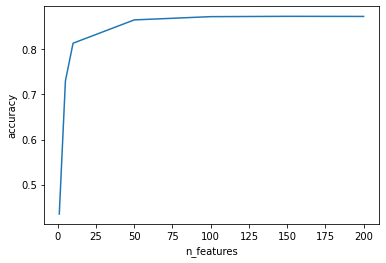

In [ ]:
import matplotlib.pyplot as plt

plt.plot(num_dims, acc)
plt.xlabel('n_features')
plt.ylabel('accuracy')

**Итог:**

Как видно до ~50 признаков скор модели растет, однако после 50 выходит на плато => можно выбирать наименьшее возможное количество фичей, удовлетворяющих получению высокой точности модели, с целью сократить время обучения.

## LogReg vs SVC

In [ ]:
rff_lr = RFFPipeline(classifier='logreg')
rff_lr.fit(x_train, y_train)
y_pred_lr = rff_lr.predict(x_test)

rff_svc = RFFPipeline(classifier='svc')
rff_svc.fit(x_train, y_train)
y_pred_svc = rff_svc.predict(x_test)


print(f'RFF LogReg: {accuracy_score(y_test, y_pred_lr)}\nRFF SVC: {accuracy_score(y_test, y_pred_svc)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFP (PCA: True, Time:  199.28721273600058
[LibSVM]RFFP (PCA: True, Time:  1039.6394152360008
RFF LogReg: 0.8659
RFF SVC: 0.8727


**Итог:**

Как видно - качество модели RFF не зависит от выбора модели, но выбор модели сильно влияет на скорость обучения.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪